In [1]:
# !pip install ultralytics -U"
import torch

In [2]:
!pip list | grep ultra

ultralytics                       8.4.2           /Users/fzngagan/deeplearning/yolo_object_detection/ultralytics
ultralytics-thop                  2.0.18


In [3]:
import sys
sys.path.append("/Users/fzngagan/deeplearning/yolo_object_detection/ultralytics")

In [4]:
from ultralytics import YOLO
from pdb import set_trace
# Load a pretrained YOLO26 nano model
model = YOLO("yolo26n.pt")

In [5]:
features = []

def capture_raw_output(module, inp, output):
    features.append(output)

hook = model.model.register_forward_hook(capture_raw_output)

In [6]:
# model.add_callback("on_predict_batch_end", lambda x: set_trace())

In [7]:
# detect_head = model.model.model[-1]  # Last layer is the Detect head
# print(type(detect_head))

In [8]:
# Run inference
# set_trace()
results = model("https://media.roboflow.com/inference/vehicles.png")


image 1/1 /Users/fzngagan/deeplearning/object-detection-experiments/vehicles.png: 416x640 3 cars, 1 truck, 41.7ms
Speed: 4.0ms preprocess, 41.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


In [9]:
# Remove hook
hook.remove()

In [10]:
for f in features[0]:
    print(type(f))

<class 'torch.Tensor'>
<class 'dict'>


In [11]:
import matplotlib.pyplot as plt

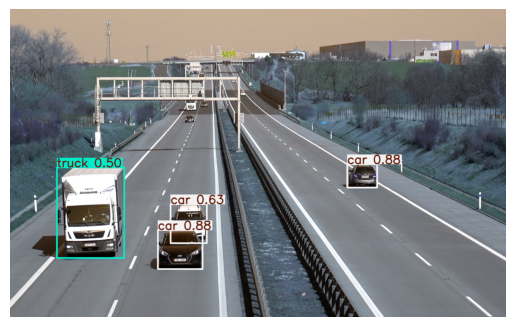

In [12]:
plotted = results[0].plot()
plt.imshow(plotted)
plt.axis('off')
plt.show()

In [13]:
# results[0].plot??

In [14]:
print(f"Raw tensor shape: {features[0][0].shape}")
print(f"Dict keys: {features[0][1].keys()}")

Raw tensor shape: torch.Size([1, 300, 6])
Dict keys: dict_keys(['one2many', 'one2one'])


In [15]:
raw_preds = features[0][0][0]  # Get first image's predictions
print(f"First detection: {raw_preds[0]}")
print(f"Max confidence: {raw_preds[:, 4].max()}")

First detection: tensor([190.7444, 293.7872, 248.3783, 344.3045,   0.8777,   2.0000])
Max confidence: 0.8776880502700806


Excellent! So each detection is [x, y, w, h, confidence, class_id] where:

(190.74, 293.79) is the center point
(248.38, 344.30) is the width and height
0.88 is the confidence score
2.0 is the class (which is 'car' from the names dict)
To plot these boxes on the original image, we need to:

Filter for high-confidence detections
Convert from center format (x, y, w, h) to corner format (x1, y1, x2, y2)
Draw rectangles on the image

In [16]:
conf = raw_preds[:,4] >= 0.5

In [17]:
cf = raw_preds[conf]

In [18]:
cf

tensor([[190.7444, 293.7872, 248.3783, 344.3045,   0.8777,   2.0000],
        [435.3542, 208.7757, 473.6769, 239.2325,   0.8767,   2.0000],
        [207.1990, 260.6324, 254.0585, 310.8635,   0.6332,   2.0000]])

In [19]:
x1 = cf[:,0] - cf[:,2]/2

In [20]:
x1

tensor([ 66.5553, 198.5158,  80.1697])

In [21]:
y1 = cf[:,1] - cf[:,3]/2

In [22]:
y1

tensor([121.6349,  89.1594, 105.2007])

In [23]:
x2 = cf[:,0] + cf[:,2]/2
x2

tensor([314.9336, 672.1927, 334.2282])

In [24]:
y2 = cf[:,1] + cf[:,3]/2

In [25]:
y2

tensor([465.9394, 328.3919, 416.0642])

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [27]:
results[0].orig_img.shape

(1308, 2108, 3)

In [28]:
model.model.args

{'task': 'detect',
 'data': '/home/lq/codes/ultralytics/ultralytics/cfg/datasets/coco.yaml',
 'imgsz': 640,
 'single_cls': False,
 'model': 'yolo26n.pt'}

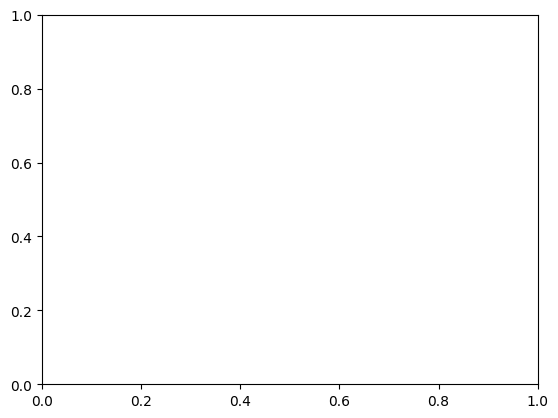

In [29]:
fig, ax = plt.subplots()

In [30]:
rps= raw_preds[:, :4].clone()

In [31]:
from ultralytics.utils import ops

scaled_boxes = ops.scale_boxes((416, 640), rps, results[0].orig_shape)


In [32]:
scaled_boxes

tensor([[ 628.2645,  938.0177,  818.0960, 1104.4091],
        [1433.9480,  658.0112, 1560.1733,  758.3283],
        [ 682.4616,  828.8143,  836.8051,  994.2630],
        ...,
        [ 736.7072,  453.0411,  787.2598,  483.0239],
        [ 598.7309,  228.6797,  623.0641,  287.1376],
        [ 746.4399,  382.9713,  795.2608,  421.8086]])

In [33]:
scaled_boxes[0]

tensor([ 628.2645,  938.0177,  818.0960, 1104.4091])

In [34]:
patches.Rectangle?

Init signature:
patches.Rectangle(
    xy,
    width,
    height,
    *,
    angle=0.0,
    rotation_point='xy',
    **kwargs,
)
Docstring:     
A rectangle defined via an anchor point *xy* and its *width* and *height*.

The rectangle extends from ``xy[0]`` to ``xy[0] + width`` in x-direction
and from ``xy[1]`` to ``xy[1] + height`` in y-direction. ::

  :                +------------------+
  :                |                  |
  :              height               |
  :                |                  |
  :               (xy)---- width -----+

One may picture *xy* as the bottom left corner, but which corner *xy* is
actually depends on the direction of the axis and the sign of *width*
and *height*; e.g. *xy* would be the bottom right corner if the x-axis
was inverted or if *width* was negative.
Init docstring:
Parameters
----------
xy : (float, float)
    The anchor point.
width : float
    Rectangle width.
height : float
    Rectangle height.
angle : float, default: 0
    Rotatio

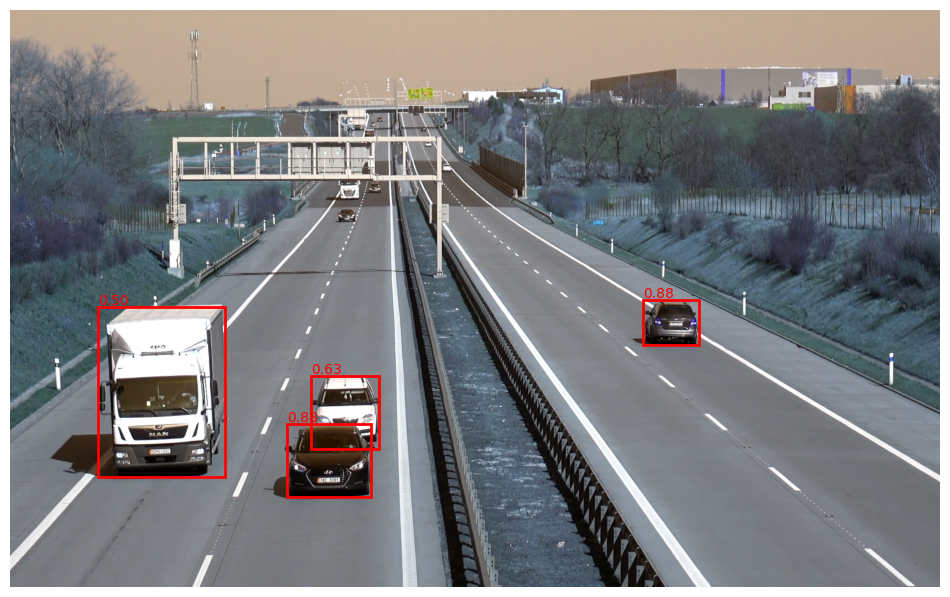

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(results[0].orig_img)

# Filter high confidence detections and draw boxes
for i, (box, pred) in enumerate(zip(scaled_boxes, raw_preds)):
    conf = pred[4].item()
    if conf >= 0.49:
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'{conf:.2f}', color='red', fontsize=10)

plt.axis('off')
plt.show()

In [36]:
print(model.predictor.batch[2])


['image 1/1 /Users/fzngagan/deeplearning/object-detection-experiments/vehicles.png: 416x640 3 cars, 1 truck, 41.7ms']


In [37]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p